In [1]:
import pandas as pd
import numpy as np


In [2]:
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import ClimateDataDTO, FutureClimateDataDTO
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )
past_climate_data_df = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(location.id)
)
future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        start_year=1970,
        start_month=1,
    )
)

await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model, x_df_test, y_df_test = (
    await climate_generative_model_repository.create_model_for_location(
        location.id
    )
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler


2024-06-11 00:26:45.692094: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 00:26:45.694423: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 00:26:45.726891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 00:26:46.389324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50


2024-06-11 00:26:48.316634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 00:26:48.317236: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0561 - root_mean_squared_error: 1.0275 - val_loss: 0.8621 - val_root_mean_squared_error: 0.9285
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0379 - root_mean_squared_error: 1.0183 - val_loss: 0.7945 - val_root_mean_squared_error: 0.8913
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0331 - root_mean_squared_error: 1.0153 - val_loss: 0.7300 - val_root_mean_squared_error: 0.8544
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8786 - root_mean_squared_error: 0.9371 - val_loss: 0.6681 - val_root_mean_squared_error: 0.8174
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9125 - root_mean_squared_error: 0.9516 - val_loss: 0.6065 - val_root_mean_squared_error: 0.7788
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6778 - root_mean_squared_error: 0.8230 - val_loss: 0.5452 - val_root_mean_squared_error: 0.7384
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7098 - root_me

In [3]:
from typing import cast


x_test_scaled = cast(np.ndarray, x_scaler.transform(x_df_test))
y_test_scaled = cast(np.ndarray, y_scaler.transform(y_df_test))

In [4]:
SEQ_LENGTH = 12

In [5]:
generated_data = await climate_generative_model_repository.generate_climate_data_from_last_past_climate_data(
    location_id=location.id # type: ignore
)
generated_data

(55, 17)
(55, 10)


surface_net_solar_radiation  soil_temperature_level_3  \
year month                                                          
2024 6                       17822304.0                297.801788   
     7                       17182536.0                294.673859   
     8                       16831880.0                294.609863   
     9                       16778004.0                294.598938   
     10                      16769625.0                294.597717   
     11                      16717308.0                294.613342   
     12                      15315992.0                295.046295   
2025 5                       13914758.0                295.479187   
     6                       13877339.0                295.306305   
     7                       13927558.0                294.594818   
     8                       13911331.0                294.568024   
     9                       13805567.0                294.393219   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   
2026 5                       13407665.0                293.735565   
     6                       13407665.0                293.735565   
     7                       13407665.0                293.735565   
     8                       13407665.0                293.735565   
     9                       13407665.0                293.735565   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   
2027 5                       13407665.0                293.735565   
     6                       13407665.0                293.735565   
     7                       13407665.0                293.735565   
     8                       13407665.0                293.735565   
     9                       13407665.0                293.735565   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   
2028 5                       13407665.0                293.735565   
     6                       13407665.0                293.735565   
     7                       13407665.0                293.735565   
     8                       13407665.0                293.735565   
     9                       13407665.0                293.735565   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   
2029 5                       13407665.0                293.735565   
     6                       13407665.0                293.735565   
     7                       13407665.0                293.735565   
     8                       13407665.0                293.735565   
     9                       13407665.0                293.735565   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   
2030 5                       13407665.0                293.735565   
     6                       13407665.0                293.735565   
     7                       13407665.0                293.735565   
     8                       13407665.0                293.735565   
     9                       13407665.0                293.735565   
     10                      13407665.0                293.735565   
     11                      13407665.0                293.735565   
     12                      13407665.0                293.735565   

            volumetric_soil_water_layer_3  total_cloud_cover  snowfall  \
year

In [6]:
from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository


# start generating from 1 year ago
seed_data = past_climate_data_df[(-12 - SEQ_LENGTH) : -12]
start_year, start_month = seed_data.index[-1]

filtered_future_climate_data_df = future_climate_data_df[
    ((future_climate_data_df.index.get_level_values("year") > start_year))
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

# this generated data start from one year ago
generated_data_df = climate_generative_model_repository.generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data,
    future_climate_data_df=filtered_future_climate_data_df,
)
true_data_df = past_climate_data_df[-12:]

In [7]:
from matplotlib import pyplot as plt

def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_430152/4066554255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]


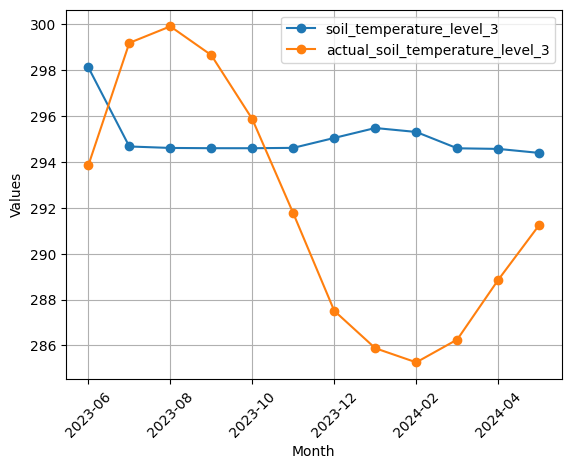

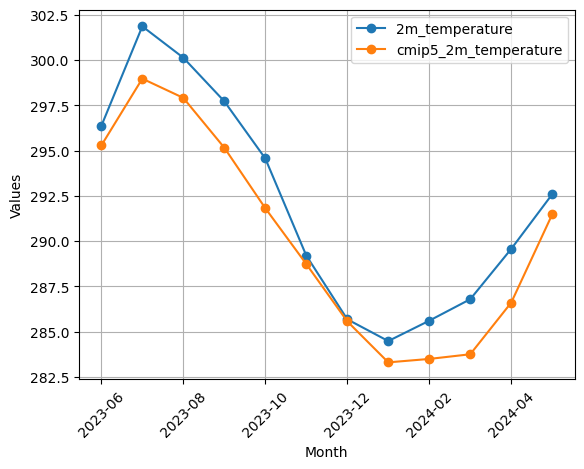

In [8]:
generated_data_df = generated_data_df[:12]
generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]
plot_values(df=generated_data_df, values=["soil_temperature_level_3", "actual_soil_temperature_level_3"])
plot_values(df=true_data_df, values=["2m_temperature", "cmip5_2m_temperature"])